<b><font size="6">Bayesian and Instance Based Learning</font></b><br>

In this notebook, we are going to cover classification of data from 2 distinct paradigms:

1. Probability-based learning (i.e. <b>Bayesian classification</b>)
2. Instance-based learning (i.e. <b>K-Nearest Neighbors</b>)



# <font color='#BFD72F'>Contents</font> <a class="anchor" id="toc"></a>

* [1 - Initial Steps](#first-bullet)
    * [1.1 - Connect to Google Colab](#first-bullet)
    * [1.2 - Importing Libraries and Data](#import)
    * [1.3 - Data Understanding](#understand)
* [2 - Holdout Method Implementation: Split and preprocess the data](#holdout)
    * [2.0 - Split](#split)
    * [2.1 - Data Preprocessing](#preprocess)
    * [2.2 - Feature Engineering](#engineer)
    * [2.3 - Scaling](#scaling)
    * [2.4 - Feature Selection](#select)
* [3 - Bayesian Classifiers](#bayes)
    * [3.1 - Gaussian NB](#gauss)
    * [3.2 - Multinomial NB](#multi)
    * [3.2 - Bernoulli NB](#bern)
* [4 - Instance Based Classifiers](#instance)
    * [4.1 - KNN Classifier](#knn)
    * [4.2 - Ball Tree](#ball)
    * [4.3 - KD Tree](#kdt)

# <font color='#BFD72F'>1. Initial Steps</font> <a class="anchor" id="first-bullet"></a>

## <font color='#BFD72F'>1.1. Connect to Google Colab</font> <a class="anchor" id="first-bullet"></a>
[Back to Contents](#toc)

**Step 1 -** Connect the google colab notebook with your google drive. Before running the code below, make sure you have this notebook in the folders mentioned in the variable `path`.<br>

In [ ]:
# Connect Google Colab to Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/Colab Notebooks/DM2/LAB03 - Bayesian and Instance Based Classification/'

Mounted at /content/drive


## <font color='#BFD72F'>1.2. Importing Libraries and Data</font><a class="anchor" id="import"></a>
[Back to Contents](#toc)

**Step 2 -** Import the needed libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, BallTree, NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

**Step 3 -** Import the data that is going to be used into `pandas` dataframes.

**Step 3.1 -** Import the Insurance dataset.

In [ ]:
insurance = pd.read_csv(path + 'data/insurance_prep.csv', #select file
                        index_col= 'InsuredID', #set index col
                       ).drop('Unnamed: 0', axis = 1) #drop useless first columns

#take a look at the data
insurance

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/DM2/3 - Bayesian and Instance Based Classification/data/insurance_prep.csv'

<font color='orange'>____GOAL____  : </font> Predict if the health plan will get an upgrade by the customer using the given features

This dataset contains 2500 rows of hospitalization data that an insurance company is analysing, where the Insurance charges are given against the following attributes of the insured: Age, Sex, BMI, Number of Children, Smoker, Region, etc.


`Insured ID`<br>
`Year_Birth` -  Insurance contractor year of birth<br>
`Gender` - (dummies)  Insurance contractor gender, female / male.<br>
`Region` - (dummies)The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.<br>
`Marital Status` - (dummies) Insurance contractor marital status<br>
`Smoker` - (dummies) Smoker / Non - smoker.<br>
`Income` - Insurance contractor income.<br>
`BMI` - Body mass index<br>
`BSA` - body surface area.<br>
`Insured_Satisfaction` - Insured satisfaction regarding insurance assistance/services covered during hospitalization.<br>
`Expenses` - Individual medical costs billed by health insurance.<br>
`Expenses in percentage (%)` by categories (Treatment / Medication / Medical_Assistance / Exams / Ambulance_Transport).<br>
`Expenses coverage percentage (%)` (Insurance_Coverage / Patient_Coverage).<br>
`Plan_Option` Type of plan insurance <br>
`Upgrade Health Plan` The customer upgraded the health plan insurance<font color='orange'> <- **Dependent Variable / Target**</font>

## <font color='#BFD72F'> 1.3. Data Understanding</font> <a class="anchor" id="understand"></a>
[Back to Contents](#toc)

In this section, you should take the time to understand your data and what it means. In this notebook we will run very simple commands to just look at the most important descriptive statistics. <br>
However, recall that **a thorough understanding of the data you have will contribute to a much smoother work on the subsequent sections and, by the end, a better model**. It is not uncommon **for the Understanding** and **Preprocessing** stages to take more than **half** of the time you spend on a project.

**Step 4:** Use the method `info()` to look at datatypes and missing values.

In [ ]:
insurance.info()

**Step 5:** Use the method `describe()` to look at the descriptive statistics of each one of your variables.

In [ ]:
insurance.describe().T

**Step 6:** Use the method value_counts() to look at the class distribution of the dependent variable.

In [ ]:
insurance['Upgrade_Health_Plan'].value_counts()

**Step 7:** Create the lists `metric_features` and `categorical_features` to store the variables that are meant to be numeric and categoric, respectively.

In [ ]:
metric_features = ['Year_Birth', 'Smoker', 'Income', 'BMI', 'BSA', 'Expenses', 'Treatment',
       'Medication', 'Medical_Assistance', 'Exams', 'Ambulance_Transport',
       'Patient_Coverage', 'Insurance_Coverage', 'Insured_Satisfaction',
       'Health_Plan_Option', 'Year_Hospitalization']

categorical_features = ['Smoker', 'Region_northwest', 'Region_southeast', 'Region_southwest',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Gender_M']

# <font color='#BFD72F'>2. Holdout Method Implementation: Split and preprocess the Data</font> <a class="anchor" id="holdout"></a>
[Back to Contents](#toc)

In this section, we will follow an implementation of the Holdout method where we are going to make a single split between training and test data.

- The training data, more than just being the set that we use to train the model, will be the **only set of data that will inform every decision we make**: scaling, feature selection, etc.
- The test data is the data that we will use to assess the performance on our model. This is the data that, allegedly, neither you nor your model should have access to before training - meaning that you should apply to it the transformations and rules derived from the training data, but **you should not use it to make any decision**.

**Step 8:** Make a copy of the insurance dataset and assign it to variable `data`.<br>
Then create variables `X` and `y`, with y being the `Upgrade_Health_Plan` and X being the remaining predictors.
<a class="anchor" id="split"></a>

In [ ]:
#copy
data = insurance.copy()

In [ ]:
#create X
X = insurance.drop('Upgrade_Health_Plan', axis = 1)
y = insurance['Upgrade_Health_Plan']

**Step 9:** Import `train_test_split` and use it to split the data into X_train, X_test, y_train and y_test, defining `test_size` as 0.25 , `random_state` equal to 5 and `stratify` by the target.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify = y,
                                                    random_state=5)

## <font color='#BFD72F'> 2.1. Preprocessing</font><a class="anchor" id="preprocess"></a>
[Back to Contents](#toc)

At this stage, we know that, at least, we have missing values in `BMI` to deal with. For the purposes of today's class we will fill them with the mean value.

<b>Note:</b> It is very important to remember that whichever decisions you make at this stage should be exclusively informed by the training data. Thus, we will compute the mean value of BMI the training data and use it to fill `BMI` for both the training and the test sets.

**Step 10:** Compute the average `BMI` of X_train and store it in variable `mean_bmi`

In [ ]:
mean_bmi = X_train['BMI'].mean()

**Step 11:** Check the number of missing values in column `BMI` in both the `X_train` and `X_test`

In [ ]:
print(f'Number of missing values in column BMI in X_train: {sum(X_train["BMI"].isna())}\n' +
     f'Number of missing values in column BMI in X_test: {sum(X_test["BMI"].isna())}')

**Step 12:** Fill the missing values in `X_train` with `mean_bmi`. Do the same to fill missing values of `BMI` in `X_test`

In [ ]:
#filling nans in X_train
X_train['BMI'].fillna(mean_bmi, inplace = True)

#filling nans in X_test
X_test['BMI'].fillna(mean_bmi, inplace = True)

**Step 13:** Check again the number of missing values in column `BMI` in both the `X_train` and `X_test`

In [ ]:
print(f'Number of missing values in column BMI in X_train: {sum(X_train["BMI"].isna())}\n' +
     f'Number of missing values in column BMI in X_test: {sum(X_test["BMI"].isna())}')

As stated, most of the dataset has already been preprocessed in advance, which means that there is very little work to be done before this dataset is ready to be used in a predictive model. There are, however, additional preprocessing steps that you can follow. For instance, the dataset may still have outliers.

<b>We will not do that on this notebook, but we will keep this is a gentle reminder of what can be done. Moreover, when reviewing this notebook, you can try to perform some additional pre-processing steps and see whether they affect (or not) the performance of your trained model.</b>

In [ ]:
#Use this section to practice pre-processing and see how different choices affect the model you create (and its performance)

## <font color='#BFD72F'> 2.2. Feature Engineering</font><a class="anchor" id="engineer"></a>
[Back to Contents](#toc)

Same as in the previous case, this block was kept as a reminder of what you need to do at this stage.<br>
You can use the following cell to create new variables and see if you can create a better model than the one you trained in class.

In [ ]:
#Use this section to practice pre-processing and see how different choices affect the model you create (and its performance)

## <font color='#BFD72F'> 2.3. Scaling</font><a class="anchor" id="scaling"></a>
[Back to Contents](#toc)

During your ML journey **you will use some algorithms that require data to be on the same scale**. Such an example can be found in popular algorithms that use distances (e.g. `KNN` that will be covered later). Moreover, that will also be the case with other popular feature selection techniques such as the Embedded Method [Lasso Regression](https://scikit-learn.org/stable/modules/feature_selection.html#l1-feature-selection).

For those reasons, you **should consider scaling your data unless you are certain that none of the techniques you use require scaled data**. As in previous classes, we will use MinMaxScaler, but keep in mind that this is not the only scaler that exists and is by no means the optimal scaling solution for all problems.

[See more options here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

**Step 14:** Create an instance of MinMaxScaler named `feature_scaler` and fit it to X_train. Then transform X_train and X_test.

In [ ]:
feature_scaler = MinMaxScaler().fit(X_train)

In [ ]:
#scale X_train and X_test using feature_scaler
X_train_scaled = pd.DataFrame(feature_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(feature_scaler.transform(X_test), columns= X_test.columns, index=X_test.index)

## <font color='#BFD72F'> 2.4. Feature Selection</font><a class="anchor" id="select"></a>
[Back to Contents](#toc)

We will use Recursive Feature Elimination (RFE), which is a Wrapper technique that selects the most important features to keep. Logistic Regression will be the base estimator to use with it.

Remember, from previous practical class, that **the sklearn implementation of RFE** requires us to tell RFE the number of features we want to keep. Usually, that is knowledge that you do not have (or at least shouldn't) apriori.

You can, however, create a loop to check the score of the estimator using a different possible numbers of features. <br>
Below you have an example that will check the score of the estimator by chosing between 2 and 15 variables. Another option would be to use [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) instead.

**Step 15:** Run the following loop to determine the optimal number of numeric features to select according to a RFE on the base estimator `Logistic Regression` on `X_train_scaled`.

Essencially, what the next cell will do is: create and train a model of a `LogisticRegression` for every possible value (between 2 and 15) of `n_features_to_select`. Then measures the performance on the test data and compare it to previous runs.
In the end, returns what is the optimal number of features to keep.

<b>Due to the imbalanced nature of the dataset, the chosen performance metric will be the *F1-score*, defined as:</b>

$$F1score=2\frac{Precision*Recall}{Precision+Recall}$$

where $$Precision=\frac{TP}{TP+FP}$$ and $$Recall=\frac{TP}{TP+FN}$$

In [ ]:
# Number of features to keep
nof_list=np.arange(2,16)
high_score=0
# Variable to store the optimum features
nof=0

#list of scores
score_list =[]

for n in range(len(nof_list)):
    model = LogisticRegression()

    #create instance of RFE
    rfe = RFE(model,n_features_to_select = nof_list[n])

    #fit RFE to training data
    X_train_rfe = rfe.fit_transform(X_train_scaled[metric_features],y_train)

    #apply the same RFE transformation to the test data
    X_test_rfe = rfe.transform(X_test_scaled[metric_features])

    #create and train instance of Logistic Regression
    model.fit(X_train_rfe,y_train)

    #predict
    y_pred = model.predict(X_test_rfe)

    #store f1score in variable
    f_score = f1_score(y_test, y_pred)

    score_list.append(f_score)

    #compare against previous best performance
    if(f_score > high_score):
        high_score = f_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

**Step 16:** Run a new `RFE` with a `LogisticRegression` base estimator. Now, make the optimal number of numerical features to keep explicit.

In [ ]:
rfe = RFE(estimator = LogisticRegression(), n_features_to_select = nof)

**Step 17:** Find the `metric_features` that RFE, trained on `X_train_scaled`, believes to be important for prediction.  

In [ ]:
#fit RFE to your training data - metric features only
X_rfe = rfe.fit_transform(X = X_train_scaled[metric_features], y = y_train)

# Create an object `selected_features` that will shows which features to keep and which features to throw away
selected_features = pd.Series(rfe.support_, index = X_train_scaled[metric_features].columns)
selected_features

We will not, in this section, worry about using other feature selection techniques. And due to the nature of the algorithms used in the next sections, we will limit our approach to numerical features.

Remember, however, that there are other techniques available to you and you should aim for a feature selection strategy that is robust to the biases of each individual technique.

You can use the following cell to perform different feature selection techniques and see if you can create a better model than the one you trained in class. Moreover, it is possible that different scaling techniques result in differences of features being selected, so you will need to pay close attention.

In [ ]:
#Use this section to practice feature selection and see how that affects the model you create (and its performance)

**Step 18:** Create a variable `selected_columns`that stores the information about which columns were selected by your feature selection strategy.

In [ ]:
selected_columns = selected_features[selected_features].index
selected_columns

**Step 19:** Filter `X_train_scaled` and `X_test_scaled` in order to keep the features present in `selected_columns` (this will be useful later).

In [ ]:
#filter train data
X_train_scaled = X_train_scaled.loc[:,selected_columns]

#filter test data
X_test_scaled = X_test_scaled.loc[:,selected_columns]

**Step 20:** Filter `X_train` and `X_test` in order to only keep the `metric_features`.

In [ ]:
#filter train data
X_train = X_train.loc[:,metric_features]

#filter test data
X_test = X_test.loc[:,metric_features]

# <font color='#BFD72F'>3. Bayesian Classifiers</font> <a class="anchor" id="bayes"></a>
[Back to Contents](#toc)

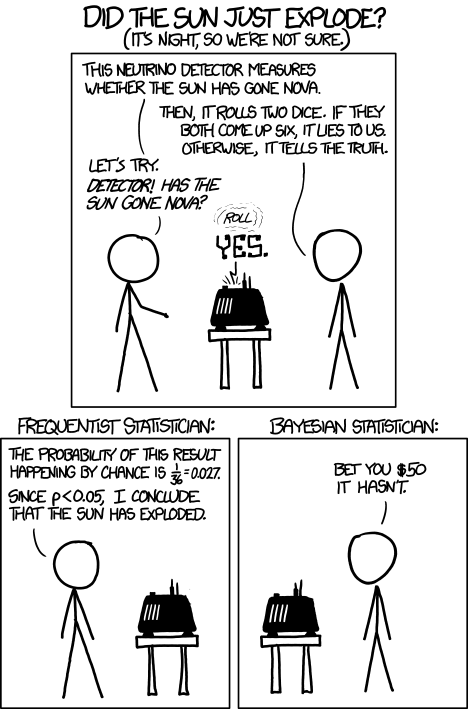


We can think of Bayes’ theorem as a way to update knowledge when presented with new evidence or data:</b>
1. We hold a preconceived notion or belief as **prior**
2. We calculate the likelihood of the data conditioned on our **prior**
3. The prior uses the data to be updated into a **posterior**

$$
Posterior = \frac{Likelihood \cdot Prior}{Evidence}
$$
<br>

Bayesian classification uses Bayes' theorem to predict class membership probabilities (i.e. the probability that a given sample belongs to a specific class). We can think of hypothesis **y** as the classification outcome or label and use the theorem to calculate the probability of **y** given the set of features $X = x_1,...,x_n$:

$$
P(y \vert X) = \frac{P(X \vert y) P(y)}{P(X)}
$$
<br>

To classify **y** given $X$, we would need to be able to compute different probabilities:
1. The prior $P(y)$,
2. The probability distribution of the data $P(X)$,
3. The likelihood of the data conditioned on the prior $P( X \vert y)$

<br>

In theory, calculating 1. and 2. should be relatively straightforward: <br>
$P(y)$ **converges to the ground truth as more data is given** to the model.<br>
$P(X)$ **has the same value for all possible classes**.<br>

The only component we would really need to compute is the probability of the features conditioned on the outcome $y$: $P(X \vert y)$.<br>

If we could find THE statistical distribution that generated the data and use it to perfectly calculate the likehoods of each feature conditioned on the outcomes. <br>
**However...**

The hypothetical statistical distribution that could have generated this data is not known and, **spoiler, cannot be known**. Moreover, the training step of such a classifier is not trivial and computationally very expensive because of:

     i. Different features are not independent
    ii. The relative importance of each feature is not obvious

## <font color='#BFD72F'> 3.0. Naive Bayes</font>
[Back to TOC](#toc)
</a>

Naive Bayes simplifies the training procedure by making mathematically convenient, albeit very naive, assumptions about the data generating model:

      i. All features are independent from one another
     ii. All features are considered to be equally important towards the outcome label
    iii. The previously unknown distribution that generated the data is assumed to follow a known statistical distribution
    
Sklearn offers multiple alternative versions of the Naive Bayes algorithm, with the main difference among them being the assumptions made concerning the distribution of $P(X|y)$ (https://scikit-learn.org/stable/modules/naive_bayes.html). In class, we will mainly focus on the Gaussian algorithm.

## <font color='#BFD72F'> 3.1. Gaussian NB</font><a class="anchor" id="gauss"></a>
[Back to TOC](#toc)

The Gaussian Naive Bayes assumes that the data for each label is generated from a simple Gaussian distribution:

$$
\begin{equation*}
P(x_{i}\mid y) = \frac{1}{\sqrt{2\pi \sigma_y^{2}}} \exp \left(-\frac{(x_{i} -\mu_{y})^2}{2\sigma_y^{2}} \right)
\end{equation*}
$$

Find the details on the implementation of this algorithm in sklearn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB">here</a>.

**Step 21:** Using `GaussianNB`, create a Naive Bayes classifier instance called `modelNB`.

In [ ]:
modelNB = GaussianNB()

### <font color='#BFD72F'> 3.1.1. Methods in GaussianNB </font>

**Step 22:** Use the `.fit()` method to fit the model to the array of points `X_train_scaled` and `y_train`, i.e., associate the argument keyword `X` and `y`.

In [ ]:
modelNB.fit(X = X_train_scaled, y = y_train)

**Step 23:** Use the `.predict()` method to perform classification in `X_train_scaled` and assign to the object `labels_train`. Do the same for `X_test_scaled` and assign to the object `labels_test`.

In [ ]:
labels_train = modelNB.predict(X_train_scaled)
labels_test = modelNB.predict(X_test_scaled)

**Step 24:** Use the `.score()` method to obtain the mean accuracy of the given train data `X_train_scaled` and the true labels, `y_train`.

In [ ]:
modelNB.score(X_train_scaled, y_train)

**Step 25:** Use the `.score()` method to obtain the mean accuracy of the given test data `X_test_scaled` and the true labels, `y_test`.

In [ ]:
modelNB.score(X_test_scaled, y_test)

By comparing the results of Step 24 and Step 25 we can verify that the accuracy of the model is slightly higher in the train dataset. Still, as discussed, in an umbalanced problem, accuracy is a **misleading** model performance metric. <br>

In these situations, you should consider other options, such as the F1_score that are not explicitly callable methods:

In [ ]:
print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

### <font color='#BFD72F'>3.1.2. Attributes in GaussianNB </font>

**Step 26:** Call the attribute `.class_prior_` to check the assumed $P(y)$ for both $y = 0$ and $y = 1$.

In [ ]:
modelNB.class_prior_

**Step 27:** Call the attribute `.class_count_` to verify the number of training samples observed in each class.

In [ ]:
modelNB.class_count_

**Step 28:** Call the attribute `.theta_` to verify the mean value of each feature per class.<br>
Remember that, each class here is scaled, so **be careful about how you interpret it**.

In [ ]:
modelNB.theta_

Note: If you dont remember the order of the variables, you can always call `X_train_scaled.columns`.

In [ ]:
pd.DataFrame(data=modelNB.theta_, columns=X_train_scaled.columns).T

**Step 29:** Call the attribute `.var_` to verify the variance of each feature per class.

In [ ]:
pd.DataFrame(data=modelNB.var_, columns=X_train_scaled.columns).T

## <font color='#BFD72F'> 3.2. Multinomial NB</font><a class="anchor" id="multi"></a>
[Back to TOC](#toc)

The Multinomial Naive Bayes algorithm assumes that the data is multinomially distributed. A multinomial distribution describes the probability of observing counts among a number of different categories. Thus, it is more adequate for features that represent counts or count rates. Its properties make it a popular algorithm in Natural Language Processing (NLP) and text classification (e.g. spam detection). <br>


The classification problem using Naive Bayes can be summarized by the equation below:

$$
H^{\text{MAP}} = \underset{i \in \{\text{spam}, \text{not-spam}\}}{\mathrm{argmax}} \left[ \prod_{j=1}^{m} P(F_j | H_i) \right] P(H_i)
$$

**MultinomialNB implements the naive Bayes algorithm for discrete counts and is one of the two classic naive Bayes variants used in text classification** (where the data are typically represented as word vector counts).


Find the implementation details of this algorithm in sklearn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB">here</a>.

## <font color='#BFD72F'> 3.3. Bernoulli NB</font><a class="anchor" id="bern"></a>
[Back to TOC](#toc)

__Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.__


Find the details on the implementation of this algorithm in sklearn <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB">here</a>.

# <font color='#BFD72F'>4. Instance Based Classifiers</font> <a class="anchor" id="instance"></a>

## <font color='#BFD72F'> 4.1. KNN Classifier</font> <a class="anchor" id="knn"></a>
[Back to Contents](#toc)

Now we are going to see the implementation of a KNN Classifier using sklearn. <br>
Notice that the syntax is quite similar to the models used up to this point.

We will continue with `insurance` scaled data (`X_train_scaled`, `X_test_scaled`, `y_train`, `y_test`).

**Step 1:** Using `KNeighborsClassifier`, create a Nearest Neighbor classifier instance called `modelKNN`. <br>

Can check the default arguments <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">here</a>.

In [ ]:
modelKNN = KNeighborsClassifier()

### <font color='#BFD72F'>4.1.1. Methods in KNeighborsClassifier </font>

**Step 2:** Use the `.fit()` method to fit the model to the array of points `X_train_scaled` and `y_train`, i.e., associate the argument keyword `X` and `y`.

In [ ]:
modelKNN.fit(X = X_train_scaled, y = y_train)

**Step 3:** Use the `.predict()` method to perform classification in `X_train_scaled` and assign to the object `labels_train`. Do the same for `X_test_scaled` and assign to the object `labels_test`.

In [ ]:
labels_train = modelKNN.predict(X_train_scaled)
labels_test = modelKNN.predict(X_test_scaled)

**Step 4:** Use the `.score()` method to obtain the mean accuracy of the given train data `X_train_scaled` and the true labels, `y_train`.

In [ ]:
modelKNN.score(X_train_scaled, y_train)

**Step 5:** Use the `.score()` method to obtain the mean accuracy of the given train data `X_test_scaled` and the true labels, `y_test`.

In [ ]:
modelKNN.score(X_test_scaled, y_test)

Again, given the dataset we are using, these accuracy scores are **misleading** as a model performance metric. <br>

Let us see what happens when we consider the F1_score, which again is not an explicitly callable methods:

In [ ]:
print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

### <font color='#BFD72F'> 4.1.2. Attributes in KNeighborsClassifier </font>

**Step 6:** Call the attribute `.classes_` to check the class labels known to the classifier.

In [ ]:
modelKNN.classes_

**Step 7:** Call the attribute `.effective_metric_` to verify the distance metric used.

In [ ]:
modelKNN.effective_metric_

### <font color='#BFD72F'> 4.1.3. Change the Number of Neighbors (k)</font>

**Step 8:** We can change the number of neighbors to consider in order to classify new instances to 3 by creating a new KNN classifier where `n_neighbors=3`. Note that the default number of neighbors is 5.

In [ ]:
modelKNN3 = KNeighborsClassifier(n_neighbors=3)

**Step 9:** Use the `.fit()` method to fit the model to the array of points `X_train_scaled` and `y_train`, i.e., associate the argument keyword `X` and `y`.

In [ ]:
modelKNN3.fit(X = X_train_scaled, y = y_train)

**Step 10:** Use the `.score()` method to obtain the mean accuracy of the given train data `X_train_scaled` and the true labels, `y_train`.

In [ ]:
modelKNN3.score(X_train_scaled, y_train)

**Step 11:** Use the `.score()` method to obtain the mean accuracy of the given train data `X_test_scaled` and the true labels, `y_test`.

In [ ]:
modelKNN3.score(X_test_scaled, y_test)

**Step 11.1:** Obtain the F1 score for the output predictions.

In [ ]:
labels_train = modelKNN3.predict(X_train_scaled)
labels_test = modelKNN3.predict(X_test_scaled)

In [ ]:
print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

#### 4.1.3.1. Choosing K

Lets compare the results between a KNN model when the number of neighbors is small and when is large...

__Note:__
1) A small number of neighbors generally leads to overfitting; <br>
2) A big number of neighbors generally leads to underfitting.<br>


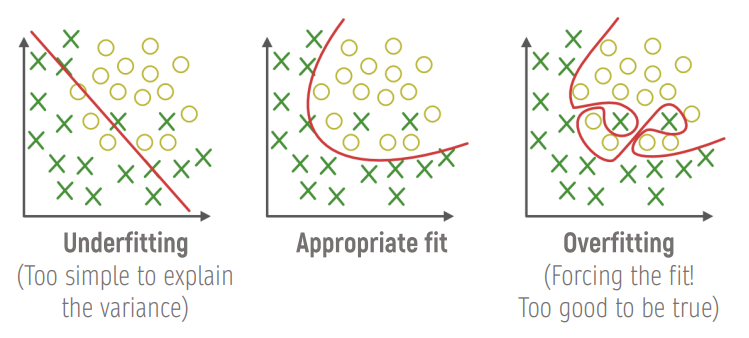

__Number of Neighbors = 1__

In [ ]:
modelKNN1 = KNeighborsClassifier(n_neighbors=1).fit(X = X_train_scaled, y = y_train)

labels_train = modelKNN1.predict(X_train_scaled)
labels_test = modelKNN1.predict(X_test_scaled)

print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

__Number of Neighbors = 5__

In [ ]:
modelKNN5 = KNeighborsClassifier().fit(X = X_train_scaled, y = y_train)

labels_train = modelKNN5.predict(X_train_scaled)
labels_test = modelKNN5.predict(X_test_scaled)

print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

__Number of Neighbors = 100__

In [ ]:
modelKNN100 = KNeighborsClassifier(n_neighbors=100).fit(X = X_train_scaled, y = y_train)

labels_train = modelKNN100.predict(X_train_scaled)
labels_test = modelKNN100.predict(X_test_scaled)

print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

**Step 12:** To identify the optimal number of neighbors to select, we can use a loop to test the mean F1-score on unseen data for k ranging between 1 to 30.<br>
Check the number of neighbors to keep and the F1 score in the train and test for that number of neighbors.

In [ ]:
numberK_list=np.arange(1,31)
high_score=0
nof=0
score_list_train =[]
score_list_test =[]
for n in numberK_list:
    model = KNeighborsClassifier(n_neighbors = n).fit(X_train_scaled, y_train)

    #obtain predictions
    labels_train = model.predict(X_train_scaled)
    labels_test = model.predict(X_test_scaled)

    score_train = f1_score(y_train, labels_train)
    score_test = f1_score(y_test, labels_test)
    score_list_train.append(score_train)
    score_list_test.append(score_test)

    if(score_test>high_score):
        high_score = score_test
        nof = numberK_list[n]
print("Best number of neighbors: %d" %nof)
print("Mean F1-score in train with %d neighbors: %f" % (nof, score_list_train[nof-1]))
print("Mean F1-score in validation with %d neighbors: %f" % (nof, high_score))

**Step 12.1:** Run the cell below to create a line plot with the train and validation scores, relative to the number of neighbors.

In [ ]:
plt.plot(numberK_list, score_list_train, label='Train')
plt.plot(numberK_list, score_list_test, label = 'Test')
plt.vlines(x=nof,ymax=high_score,ymin=min(score_list_test),ls='--',colors='g')
plt.xticks(numberK_list)
plt.xlabel('k')
plt.ylabel('score')
plt.legend()
plt.xticks(np.arange(0,31,2))
plt.show()

### <font color='#BFD72F'> 4.1.4 Change the Distance Metric</font>

**Step 13:** We can change the distance used from `Euclidean` to others such as the `Manhattan` distance by creating a new KNN classifier where `metric` = manhattan.

In [ ]:
modelKNNM = KNeighborsClassifier(metric='manhattan')

**Step 14:** Use the `.fit()` method to fit the model to the array of points `X_train_scaled` and `y_train`, i.e., associate the argument keyword `X` and `y`.

In [ ]:
modelKNNM.fit(X = X_train_scaled, y = y_train)

**Step 15:** Use the `.predict()` method to perform classification in `X_train_scaled` and assign to the object `labels_train`. Do the same for `X_test_scaled` and assign to the object `labels_test`.

In [ ]:
labels_train = modelKNNM.predict(X_train_scaled)
labels_test = modelKNNM.predict(X_test_scaled)

**Step 15.1:** Obtain the F1 score for the output predictions.

In [ ]:
print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

__What is the difference between using the Euclidean or Manhattan Distance?__

In <a href=https://bib.dbvis.de/uploadedFiles/155.pdf> this paper</a>, the authors defend that Manhattan distance may be preferable to Euclidean distance for the case of high dimensional data.

### <font color='#BFD72F'> 4.1.5. Distance Weighted KNN</font>

**Step 16:** We can change the distance weighted in KNN by changing the weights from uniform (so all neighbors have the same weight), which is the default setting, to `weights='distance'`.

In [ ]:
modelKNNW= KNeighborsClassifier(weights='distance')

**Step 17:** Use the `.fit()` method to fit the model to the array of points `X_train_scaled` and `y_train`, i.e., associate the argument keyword `X` and `y`.

In [ ]:
modelKNNW.fit(X = X_train_scaled, y = y_train)

**Step 18:** Use the `.predict()` method to perform classification in `X_train_scaled` and assign to the object `labels_train`. Do the same for `X_test_scaled` and assign to the object `labels_test`.

In [ ]:
labels_train = modelKNNW.predict(X_train_scaled)
labels_test = modelKNNW.predict(X_test_scaled)

**Step 18.1:** Obtain the F1 score for the output predictions.

In [ ]:
print(f'F1 Score between the y_train and labels_train: {f1_score(y_train, labels_train):.3f}\n' +
     f'F1 Score between the y_test and labels_test: {f1_score(y_test, labels_test):.3f}')

## <font color='#BFD72F'> 4.2. Ball Tree</font> <a class="anchor" id="ball"></a>
[Back to Contents](#toc)

Now lets briefly check the implementation of Ball Tree using sklearn to discover of neighborhood points.

**Step 19:** Using `BallTree`, create an instance called `btree`, using `X_train_scaled`. <br>

More information <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree">here</a>.

In [ ]:
btree = BallTree(X_train_scaled)

**Step 20:** Query the tree for k=5 nearest neighbors.

In [ ]:
btree.query(X_train_scaled, k=5, return_distance=False)

**Step 20.1:** Check if the first datapoints are close.

In [ ]:
X_train_scaled.iloc[[0, 553, 242, 479, 278]]

**Step 21:** Check the neighbors using `NearestNeighbors()`, an unsupervised learner for implementing neighbor searches.

More information <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors">here</a>.

In [ ]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_train_scaled)
nbrs.kneighbors(X_train_scaled)[1]

## <font color='#BFD72F'> 4.3. KD Tree</font> <a class="anchor" id="kdt"></a>
[Back to Contents](#toc)

Sklearn also has an inplementation for KD Tree as described <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree">here</a>, but can also use `NearestNeighbors()`.

**Step 22:** Check the 5 nearest neighbors using `NearestNeighbors()`, with `algorithm`='kd_tree', and compare with the previous.

In [ ]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(X_train_scaled)
dist, ind = nbrs.kneighbors(X_train_scaled)
ind

## Don't forget to practice at home :)